# Script to visualize predictions of a Model
Utilized to create single figures for the Beleg

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
import keras.backend as K
import os

## Custom Loss Function needed to allow loading of Model

In [3]:
# the custom loss function
def Masked_Mean_Absolute_Error(y_true, y_pred):
    '''Binary mean absolute error custom loss function'''
    # create binary artifact maps from ground truth depth maps
    A_i = K.greater(y_true, 0)
    A_i = K.cast(A_i, dtype='float32')
    loss = K.sum(
                K.sum(
                        K.abs(y_true - y_pred) * A_i, 
                        axis=(1,2,3)
                ) 
                    /
                K.sum(
                        A_i,
                        axis=(1,2,3)
                )
           )
    return loss

## Different Path Variables

In [4]:
path_models = '/media/julien/Transcend/Beleg/models'
path_images = 'Images'

## Load the Models to Visualize

In [5]:
model_mae = load_model(os.path.join(path_models, 'model_mae.h5'))
model_mmae = load_model(os.path.join(path_models, 'model_bmae.h5'), custom_objects={'Binary_Mean_Absolut_Error': Masked_Mean_Absolute_Error})

W1118 15:13:57.062203 140320939038528 deprecation_wrapper.py:119] From /home/julien/anaconda3/envs/mlenv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1118 15:13:57.626405 140320939038528 deprecation_wrapper.py:119] From /home/julien/anaconda3/envs/mlenv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1118 15:13:57.714297 140320939038528 deprecation_wrapper.py:119] From /home/julien/anaconda3/envs/mlenv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1118 15:13:57.715671 140320939038528 deprecation_wrapper.py:119] From /home/julien/anaconda3/envs/mlenv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is depre

## Load the images

In [8]:
color = cv2.imread(os.path.join(path_images, '44_color.jpg'), cv2.IMREAD_COLOR)
depth = cv2.imread(os.path.join(path_images, '44_depth.png'), cv2.IMREAD_ANYDEPTH)
ir = cv2.imread(os.path.join(path_images, '44_infrared.png'), cv2.IMREAD_ANYDEPTH)

img_c = (color/255.).astype(np.float32).reshape(1,480,640,3)
img_ir = (ir/65535.).astype(np.float32).reshape(1,480,640,1)

print('Color: ' + str(color.shape) + ' ' + str(color.dtype))
print('Rescaled Color: ' + str(img_c.shape) + ' ' + str(img_c.dtype))
print('Infrared: ' + str(ir.shape) + ' ' + str(ir.dtype))
print('Rescaled Infrared: ' + str(img_ir.shape) + ' ' + str(img_ir.dtype))
print('Depth: ' + str(depth.shape) + ' ' + str(depth.dtype))

Color: (480, 640, 3) uint8
Rescaled Color: (1, 480, 640, 3) float32
Infrared: (480, 640) uint16
Rescaled Infrared: (1, 480, 640, 1) float32
Depth: (480, 640) uint16


## Predict the Depth with each of the Models

In [9]:
pred_mae = model_mae.predict([img_c, img_ir])
pred_mmae = model_mmae.predict([img_c, img_ir])

print('Prediction MAE: ' + str(pred_mae.shape) + ' ' + str(pred_mae.dtype))
print('Prediction MMAE: ' + str(pred_mmae.shape) + ' ' + str(pred_mmae.dtype))

Prediction MAE: (1, 480, 640, 1) float32
Prediction MMAE: (1, 480, 640, 1) float32


## Print Min and Max Values from Predictions and Ground Truth

In [10]:
print('Prediction MAE Max / Min: ' + str(np.amax(pred_mae)) + ' / ' + str(np.amin(pred_mae)))
print('Prediction MMAE Max / Min: ' + str(np.amax(pred_mmae)) + ' / ' + str(np.amin(pred_mmae)))
print('Ground Truth Max / Min: ' + str(np.amax(depth)) + ' / ' + str(np.amin(depth)))

Prediction MAE Max / Min: 12702.883 / -391.0193
Prediction MMAE Max / Min: 61975.363 / -72210.56
Ground Truth Max / Min: 13118 / 0


## Transform to uint16 and Print Values again

In [9]:
mae = np.clip(pred_mae, 0, 65535)
mae = mae.astype(np.uint16).reshape(480,640)
mmae = np.clip(pred_mmae, 0, 65535)
mmae = pred_mmae.astype(np.uint16).reshape(480,640)

print('Prediction MAE Max / Min: ' + str(np.amax(mae)) + ' / ' + str(np.amin(mae)))
print('Prediction MMAE Max / Min: ' + str(np.amax(mmae)) + ' / ' + str(np.amin(mmae)))
print('Ground Truth Max / Min: ' + str(np.amax(depth)) + ' / ' + str(np.amin(depth)))

Prediction MAE Max / Min: 12702 / 0
Prediction MMAE Max / Min: 65532 / 4
Ground Truth Max / Min: 13118 / 0


Ground Truth


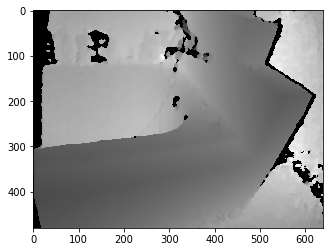

MAE


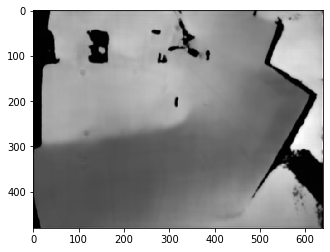

MMAE


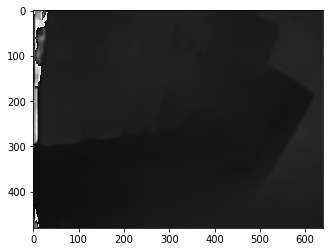

MMAE edited


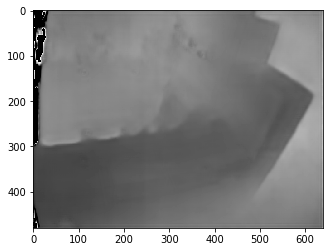

In [10]:
%matplotlib inline
print('Ground Truth')
plt.imshow(depth, cmap="gray")
plt.show()
print('MAE')
plt.imshow(mae, cmap="gray")
plt.show()
print('MMAE')
plt.imshow(mmae, cmap="gray")
plt.show()
mmae_edited = mmae.copy()
mmae_edited[mmae_edited>15000] = 0
print('MMAE edited')
plt.imshow(mmae_edited, cmap="gray")
plt.show()

## Save Results

In [69]:
cv2.imwrite(os.path.join(path_images, 'val_2_pred_mae.png'), mae)
cv2.imwrite(os.path.join(path_images, 'val_2_pred_mmae.png'), mmae)
cv2.imwrite(os.path.join(path_images, 'val_2_pred_mmae_edited.png'), mmae_edited)

True

## Normalize Predictions and Ground Truth for later Colorization

In [11]:
#norm_depth = np.zeros(shape=depth.shape, dtype=np.uint16)
#norm_mae = np.zeros(shape=mae.shape, dtype=np.uint16)
#norm_mmae = np.zeros(shape=mmae.shape, dtype=np.uint16)
#norm_mmae_edited = np.zeros(shape=mmae_edited.shape, dtype=np.uint16)

norm_depth = cv2.normalize(depth, None, 0, 65535, cv2.NORM_MINMAX)
norm_mae = cv2.normalize(mae, None, 0, 65535, cv2.NORM_MINMAX)
norm_mmae = cv2.normalize(mmae, None, 0, 65535, cv2.NORM_MINMAX)
norm_mmae_edited = cv2.normalize(mmae_edited, None, 0, 65535, cv2.NORM_MINMAX)

### Visualize Normalization

Ground Truth


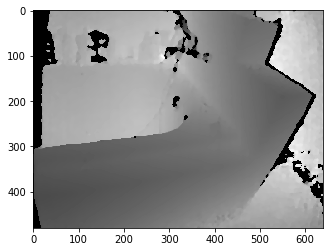

MAE


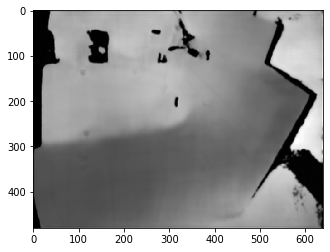

MMAE


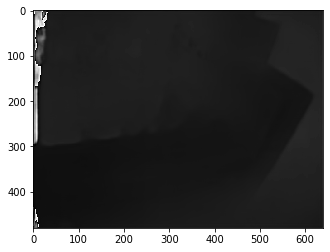

MMAE edited


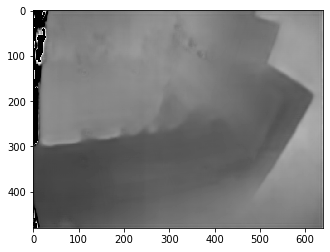

In [12]:
%matplotlib inline
print('Ground Truth')
plt.imshow(norm_depth, cmap="gray")
plt.show()
print('MAE')
plt.imshow(norm_mae, cmap="gray")
plt.show()
print('MMAE')
plt.imshow(norm_mmae, cmap="gray")
plt.show()
print('MMAE edited')
plt.imshow(norm_mmae_edited, cmap="gray")
plt.show()

## Stack images into one image

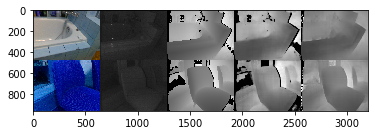

True

In [41]:
%matplotlib inline

# load already computed images
g_color = cv2.imread(os.path.join(path_images, 'buffer', '5143_color.jpg'), cv2.IMREAD_COLOR)
g_ir = cv2.imread(os.path.join(path_images, 'buffer', '5143_infrared.png'), cv2.IMREAD_ANYDEPTH)
g_ir = cv2.cvtColor((g_ir/256).astype(np.uint8), cv2.COLOR_GRAY2RGB)
n_depth = cv2.imread(os.path.join(path_images, 'buffer', 'train_norm_pred_depth.png'), cv2.IMREAD_ANYDEPTH)
n_depth = cv2.cvtColor((n_depth/256).astype(np.uint8), cv2.COLOR_GRAY2RGB)
n_mae = cv2.imread(os.path.join(path_images, 'buffer', 'train_norm_pred_mae.png'), cv2.IMREAD_ANYDEPTH)
n_mae = cv2.cvtColor((n_mae/256).astype(np.uint8), cv2.COLOR_GRAY2RGB)
n_mmae_edited = cv2.imread(os.path.join(path_images, 'buffer', 'train_norm_pred_mmae_edited.png'), cv2.IMREAD_ANYDEPTH)
n_mmae_edited = cv2.cvtColor((n_mmae_edited/256).astype(np.uint8), cv2.COLOR_GRAY2RGB)

ir_col = cv2.cvtColor((ir/256).astype(np.uint8), cv2.COLOR_GRAY2RGB)
depth_col = cv2.cvtColor((norm_depth/256).astype(np.uint8), cv2.COLOR_GRAY2RGB)
mae_col = cv2.cvtColor((norm_mae/256).astype(np.uint8), cv2.COLOR_GRAY2RGB)
mmae_edited_col = cv2.cvtColor((norm_mmae_edited/256).astype(np.uint8), cv2.COLOR_GRAY2RGB)
overview = np.concatenate((color, ir_col, depth_col, mae_col, mmae_edited_col), axis=1) # , norm_depth, norm_mae, norm_mmae_edited
overview2 = np.concatenate((g_color, g_ir, n_depth, n_mae, n_mmae_edited), axis=1)
result = np.concatenate((overview, overview2), axis=0)
plt.imshow(result)
plt.show()
cv2.imwrite(os.path.join(path_images, 'combination_result.png'), result)

## Save normalized images

In [91]:
cv2.imwrite(os.path.join(path_images, 'train_norm_pred_mae.png'), norm_mae)
cv2.imwrite(os.path.join(path_images, 'train_norm_pred_mmae.png'), norm_mmae)
cv2.imwrite(os.path.join(path_images, 'train_norm_pred_mmae_edited.png'), norm_mmae_edited)
cv2.imwrite(os.path.join(path_images, 'train_norm_pred_depth.png'), norm_depth)

True

## Colorize Depth Predictions and Ground Truth

In [77]:
color_depth = cv2.applyColorMap((norm_depth/256).astype(np.uint8), 2)
color_mae = cv2.applyColorMap((norm_mae/256).astype(np.uint8), 2)
color_mmae = cv2.applyColorMap((norm_mmae/256).astype(np.uint8), 2)
color_mmae_edited = cv2.applyColorMap((norm_mmae_edited/256).astype(np.uint8), 2)

Ground Truth


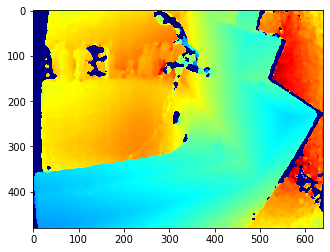

MAE


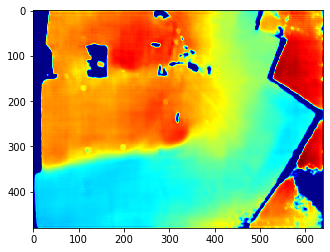

MMAE Edited


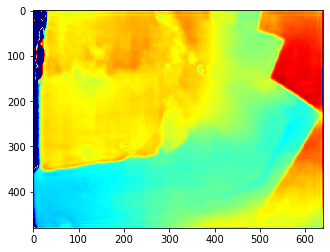

MMAE


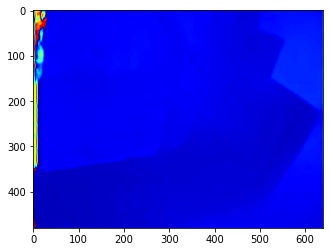

In [79]:
%matplotlib inline
print('Ground Truth')
plt.imshow(cv2.cvtColor(color_depth, cv2.COLOR_BGR2RGB))
plt.show()
print('MAE')
plt.imshow(cv2.cvtColor(color_mae, cv2.COLOR_BGR2RGB))
plt.show()
print('MMAE Edited')
plt.imshow(cv2.cvtColor(color_mmae_edited, cv2.COLOR_BGR2RGB))
plt.show()
print('MMAE')
plt.imshow(cv2.cvtColor(color_mmae, cv2.COLOR_BGR2RGB))
plt.show()